## Import Library dan Konfigurasi


In [ ]:
# Import Pustaka Standar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Scikit-Learn untuk Preprocessing & Model
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, roc_auc_score, roc_curve, f1_score)

# Import Imbalanced-Learn untuk SMOTE
from imblearn.over_sampling import SMOTE

# Library untuk Saving Model
import joblib

# Konfigurasi Visualisasi
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

print(" Semua library berhasil di-load.")

 Semua library berhasil di-load.


### Load Data dan Visualisasi EDA

In [ ]:
# Load Dataset
try:
    df = pd.read_csv('water_potability.csv')
    print(f" Dataset dimuat dengan dimensi: {df.shape}")
except FileNotFoundError:
    print(" File tidak ditemukan. Upload dulu 'water_potability.csv'.")

# Cek 5 Data Teratas
display(df.head())

# Cek Info Tipe Data & Missing Values
print("\n=== Informasi Dataset ===")
df.info()

 Dataset dimuat dengan dimensi: (3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0



=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


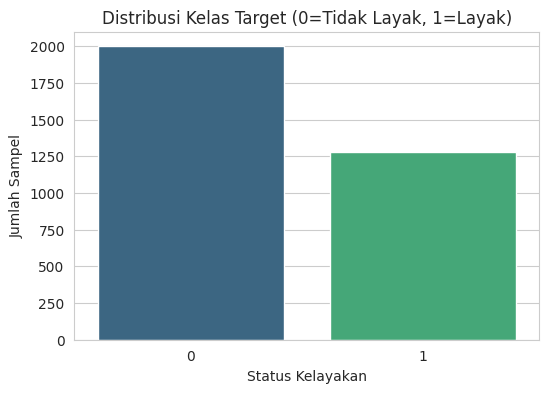

Jumlah Tidak Layak (0): 1998 (60.99%)
Jumlah Layak (1): 1278 (39.01%)
Insight: Data tidak seimbang (Imbalanced). Kita perlu SMOTE nanti.


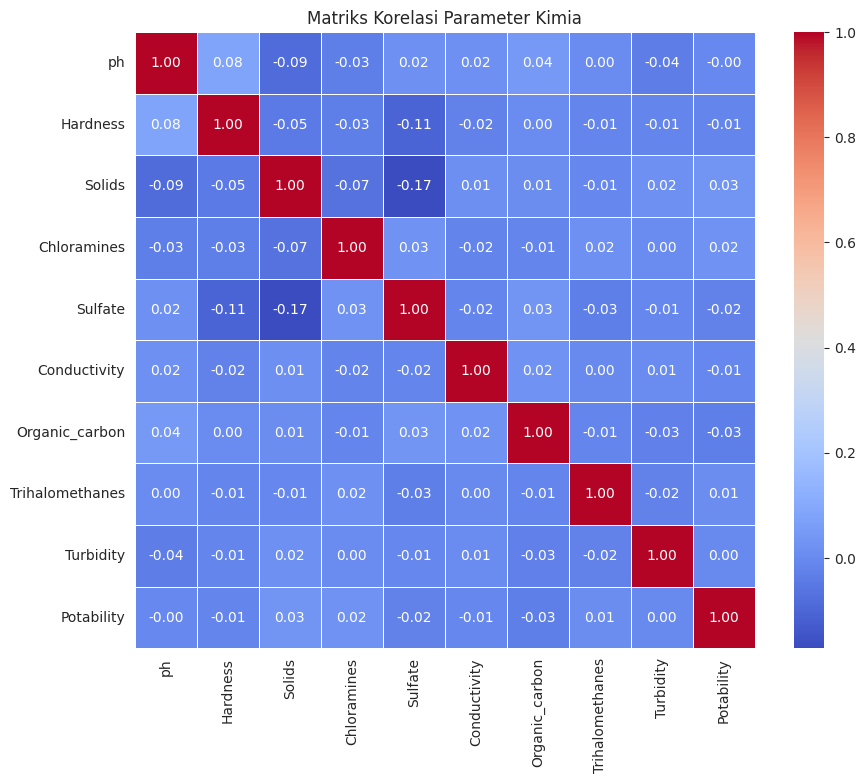

In [ ]:
# 1. Cek Keseimbangan Kelas Target
plt.figure(figsize=(6, 4))
sns.countplot(x='Potability', data=df, palette='viridis')
plt.title('Distribusi Kelas Target (0=Tidak Layak, 1=Layak)')
plt.xlabel('Status Kelayakan')
plt.ylabel('Jumlah Sampel')
plt.show()

# Hitung Rasio
count_0 = len(df[df['Potability']==0])
count_1 = len(df[df['Potability']==1])
print(f"Jumlah Tidak Layak (0): {count_0} ({count_0/len(df)*100:.2f}%)")
print(f"Jumlah Layak (1): {count_1} ({count_1/len(df)*100:.2f}%)")
print("Insight: Data tidak seimbang (Imbalanced). Kita perlu SMOTE nanti.")

# 2. Cek Korelasi Antar Fitur (Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Matriks Korelasi Parameter Kimia')
plt.show()

### Data Preprocessing


In [ ]:
# ==========================================
# 3. PREPROCESSING (LEAKAGE-FREE)
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# A. Pisahkan Fitur (X) dan Target (y)
X = df.drop('Potability', axis=1)
y = df['Potability']

# B. SPLIT DATA DULU (Wajib di awal!)
# Kita kunci random_state=42 agar hasil konsisten dengan aplikasi nanti
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensi X_train awal: {X_train.shape}")
print(f"Dimensi X_test awal : {X_test.shape}")

# C. IMPUTASI (Mengisi Data Kosong)
# Gunakan 'mean' agar konsisten dengan script generate_model.py
imputer = SimpleImputer(strategy='mean')

# PENTING: Fit hanya pada X_train! (Jangan intip data test)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test) # Data test cuma numpang transform

print("Data kosong telah diisi (Metode: Mean).")

Dimensi X_train awal: (2620, 9)
Dimensi X_test awal : (656, 9)
Data kosong telah diisi (Metode: Mean).


Menyeimbangkan data latih dengan SMOTE...
Distribusi Target Sebelum SMOTE: {0: 1598, 1: 1022}
Distribusi Target Sesudah SMOTE: {0: 1598, 1: 1598}


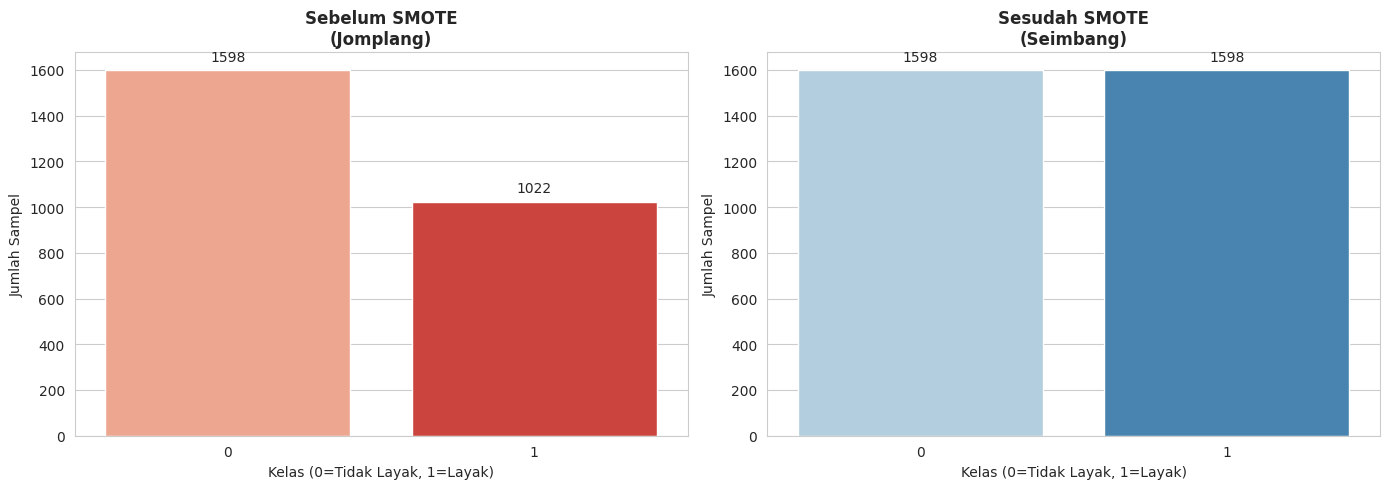


Melakukan Scaling (StandardScaler)...
Scaling selesai. Data siap untuk modeling.


In [ ]:
# ==========================================
# HANDLING IMBALANCE & SCALING (+ VISUALISASI)
# ==========================================
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Kita butuh pandas untuk visualisasi scaling

# --- D. SMOTE (Hanya pada Data Latih) ---
print("Menyeimbangkan data latih dengan SMOTE...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_imputed, y_train)

print(f"Distribusi Target Sebelum SMOTE: {y_train.value_counts().to_dict()}")
print(f"Distribusi Target Sesudah SMOTE: {y_train_resampled.value_counts().to_dict()}")

# --- VISUALISASI 1: EFEK SMOTE (BEFORE VS AFTER) ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Sebelum SMOTE
sns.countplot(x=y_train, ax=axes[0], palette='Reds')
axes[0].set_title(f"Sebelum SMOTE\n(Jomplang)", fontsize=12, fontweight='bold')
axes[0].set_xlabel('Kelas (0=Tidak Layak, 1=Layak)')
axes[0].set_ylabel('Jumlah Sampel')
# Menambahkan label angka di batang
for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

# Plot Sesudah SMOTE
sns.countplot(x=y_train_resampled, ax=axes[1], palette='Blues')
axes[1].set_title(f"Sesudah SMOTE\n(Seimbang)", fontsize=12, fontweight='bold')
axes[1].set_xlabel('Kelas (0=Tidak Layak, 1=Layak)')
axes[1].set_ylabel('Jumlah Sampel')
# Menambahkan label angka
for p in axes[1].patches:
    axes[1].annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.tight_layout()
plt.show()

# --- E. SCALING (Normalisasi) ---
print("\nMelakukan Scaling (StandardScaler)...")
scaler = StandardScaler()

# Fit pada data latih yang sudah di-SMOTE
X_train_final = scaler.fit_transform(X_train_resampled)
# Transform data uji
X_test_final = scaler.transform(X_test_imputed)

print("Scaling selesai. Data siap untuk modeling.")

### Modeling & Evaluasi

In [ ]:
# ==========================================
# 4. MODELING (KOMPARASI KNN vs RANDOM FOREST)
# ==========================================
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

print("Memulai Training Model...")

# --- MODEL 1: K-NEAREST NEIGHBORS (KNN) ---
# KNN sangat butuh data yang sudah di-scaling (X_train_final)
print("Melatih KNN (n_neighbors=5)...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_final, y_train_resampled)

# --- MODEL 2: RANDOM FOREST ---
# Random Forest lebih tangguh, tapi tetap kita pakai data yang sama biar adil
print("Melatih Random Forest (n_estimators=100)...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train_resampled)

print("Kedua model selesai dilatih.")

Memulai Training Model...
Melatih KNN (n_neighbors=5)...
Melatih Random Forest (n_estimators=100)...
Kedua model selesai dilatih.


### Evaluasi & Komparasi Model

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# --- A. PREDIKSI ---
# Prediksi KNN
y_pred_knn = knn_model.predict(X_test_final)
y_prob_knn = knn_model.predict_proba(X_test_final)[:, 1]

# Prediksi Random Forest
y_pred_rf = rf_model.predict(X_test_final)
y_prob_rf = rf_model.predict_proba(X_test_final)[:, 1]

# --- B. CETAK HASIL ---
print("\n" + "="*40)
print("HASIL PERBANDINGAN AKURASI")
print("="*40)
acc_knn = accuracy_score(y_test, y_pred_knn)
acc_rf = accuracy_score(y_test, y_pred_rf)

print(f"🔹 Akurasi KNN           : {acc_knn*100:.2f}%")
print(f"🔹 Akurasi Random Forest : {acc_rf*100:.2f}%")

if acc_rf > acc_knn:
    print(f"\n🏆 Pemenang: Random Forest (Unggul {(acc_rf - acc_knn)*100:.2f}%)")
else:
    print(f"\n🏆 Pemenang: KNN (Unggul {(acc_knn - acc_rf)*100:.2f}%)")

# --- C. CLASSIFICATION REPORT LENGKAP ---
print("\n" + "-"*20 + " DETAIL KNN " + "-"*20)
print(classification_report(y_test, y_pred_knn))

print("\n" + "-"*20 + " DETAIL RANDOM FOREST " + "-"*20)
print(classification_report(y_test, y_pred_rf))


HASIL PERBANDINGAN AKURASI
🔹 Akurasi KNN           : 57.93%
🔹 Akurasi Random Forest : 64.33%

🏆 Pemenang: Random Forest (Unggul 6.40%)

-------------------- DETAIL KNN --------------------
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       400
           1       0.47      0.53      0.50       256

    accuracy                           0.58       656
   macro avg       0.57      0.57      0.57       656
weighted avg       0.59      0.58      0.58       656


-------------------- DETAIL RANDOM FOREST --------------------
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       400
           1       0.55      0.48      0.51       256

    accuracy                           0.64       656
   macro avg       0.62      0.61      0.61       656
weighted avg       0.64      0.64      0.64       656



## Visualisasi Confusion Matrix

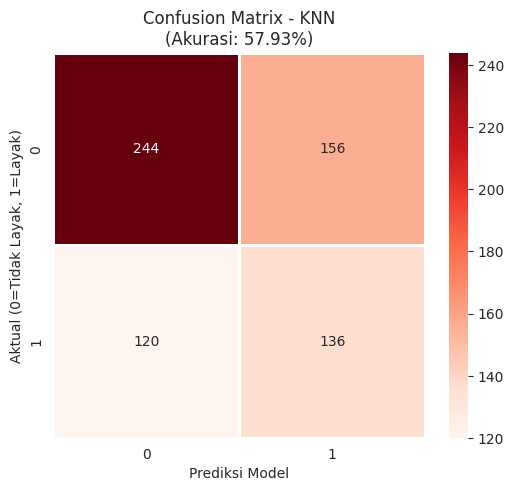

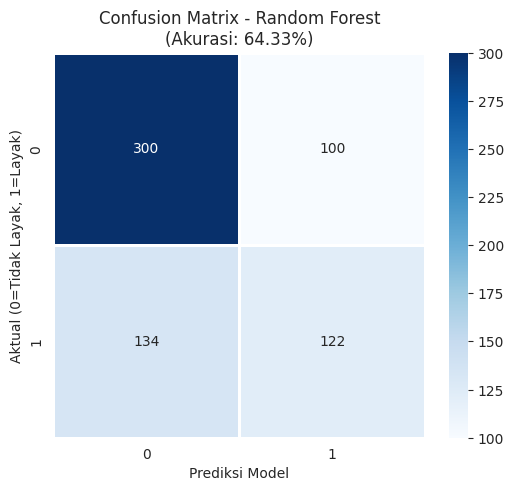

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- GAMBAR 1: CONFUSION MATRIX KNN ---
plt.figure(figsize=(6, 5))
# Membuat heatmap warna Merah (Reds) untuk KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Reds', linewidths=1)
plt.title(f'Confusion Matrix - KNN\n(Akurasi: {acc_knn*100:.2f}%)')
plt.ylabel('Aktual (0=Tidak Layak, 1=Layak)')
plt.xlabel('Prediksi Model')
plt.show() # Tampilkan gambar pertama

# --- GAMBAR 2: CONFUSION MATRIX RANDOM FOREST ---
plt.figure(figsize=(6, 5))
# Membuat heatmap warna Biru (Blues) untuk Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', linewidths=1)
plt.title(f'Confusion Matrix - Random Forest\n(Akurasi: {acc_rf*100:.2f}%)')
plt.ylabel('Aktual (0=Tidak Layak, 1=Layak)')
plt.xlabel('Prediksi Model')
plt.show() # Tampilkan gambar kedua

## Visualisasi ROC


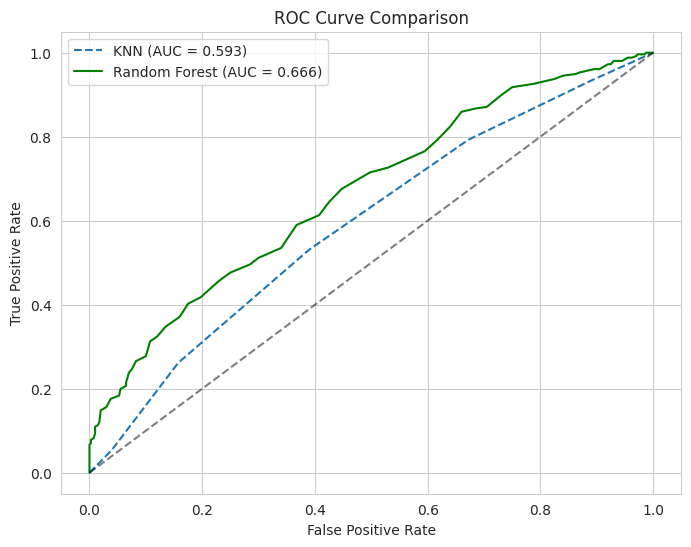

In [ ]:
# Menghitung AUC Score
auc_knn = roc_auc_score(y_test, y_prob_knn)
auc_rf = roc_auc_score(y_test, y_prob_rf)

# Plot ROC Curve
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.3f})', linestyle='--')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5) # Garis diagonal (random guess)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

## Hyperparameter Tuning

In [ ]:
# Parameter Grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf_base = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(estimator=rf_base, param_distributions=param_dist,
                               n_iter=20, cv=3, verbose=1, random_state=42, n_jobs=-1)

print("Memulai Tuning Random Forest...")
rf_random.fit(X_train_final, y_train_resampled)

# Hasil Terbaik
best_rf = rf_random.best_estimator_
print(f"\nParameter Terbaik: {rf_random.best_params_}")

# Evaluasi Model Tuning
y_pred_tuned = best_rf.predict(X_test_final)
print("\n=== Performa Random Forest Setelah Tuning ===")
print(classification_report(y_test, y_pred_tuned))

Memulai Tuning Random Forest...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Parameter Terbaik: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': False}

=== Performa Random Forest Setelah Tuning ===
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       400
           1       0.55      0.46      0.51       256

    accuracy                           0.64       656
   macro avg       0.62      0.61      0.61       656
weighted avg       0.64      0.64      0.64       656



## Interpretasi & Feature Importance


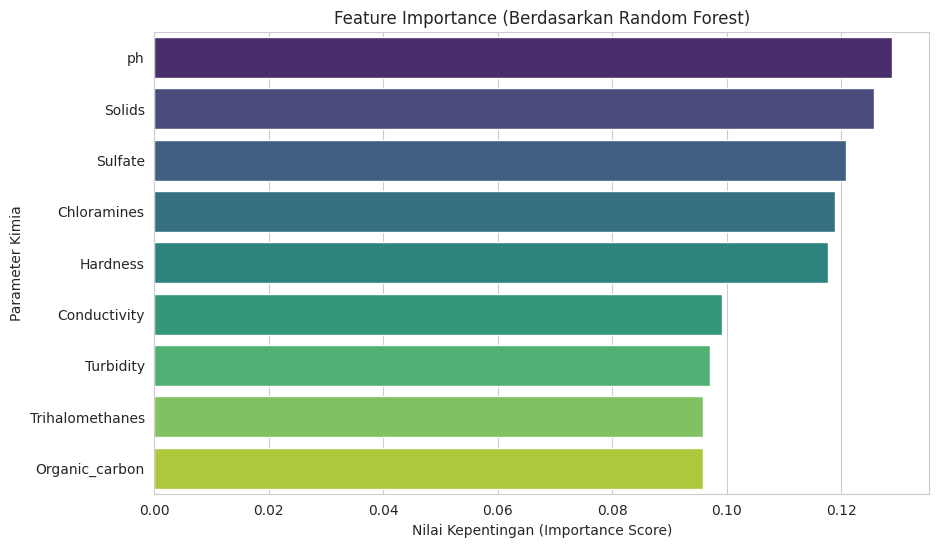

In [ ]:
# Ambil Feature Importance dari Model Terbaik
importances = best_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')
plt.title('Feature Importance (Berdasarkan Random Forest)')
plt.xlabel('Nilai Kepentingan (Importance Score)')
plt.ylabel('Parameter Kimia')
plt.show()

## Distribusi Tiap Parameter

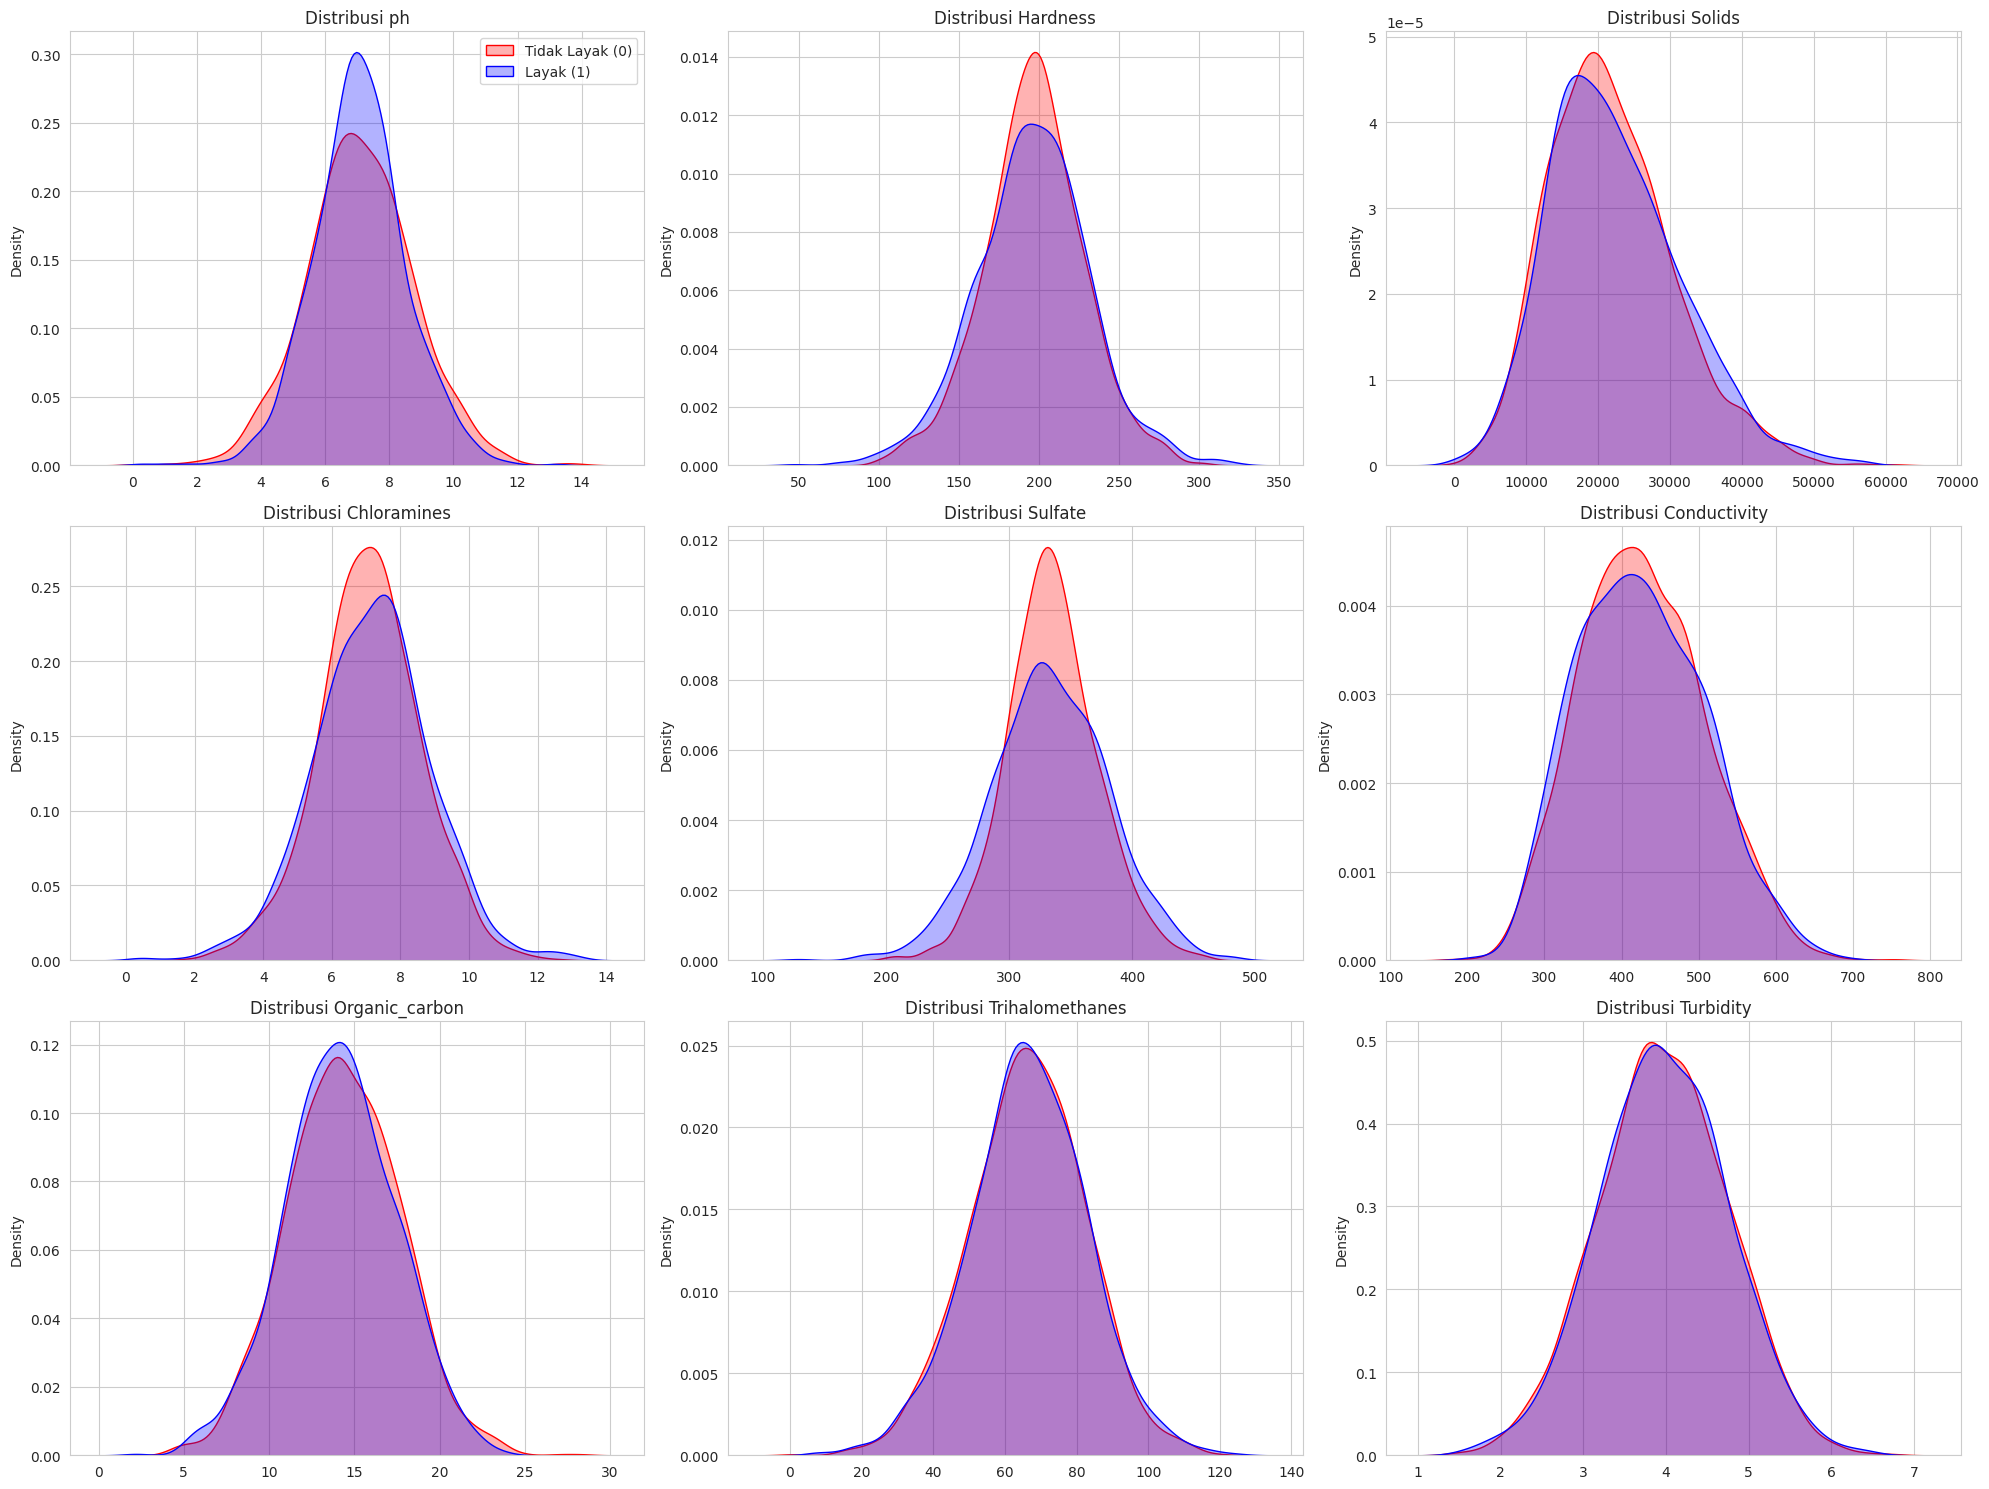

In [ ]:

plt.figure(figsize=(20, 15))
# List kolom numerik (semua kecuali target)
features = df.columns.drop('Potability')

for i, col in enumerate(features):
    plt.subplot(3, 3, i + 1) # Membuat grid 3x3

    # Plot KDE (Kernel Density Estimate) - Garis halus distribusi
    sns.kdeplot(data=df[df['Potability'] == 0][col], label='Tidak Layak (0)', shade=True, color='red', alpha=0.3)
    sns.kdeplot(data=df[df['Potability'] == 1][col], label='Layak (1)', shade=True, color='blue', alpha=0.3)

    plt.title(f'Distribusi {col}', fontsize=12)
    plt.xlabel('')
    plt.ylabel('Density')
    if i == 0: plt.legend() # Tampilkan legenda hanya di plot pertama agar rapi

plt.tight_layout()
plt.show()

## BOXPLOT PERBANDINGAN KELAS

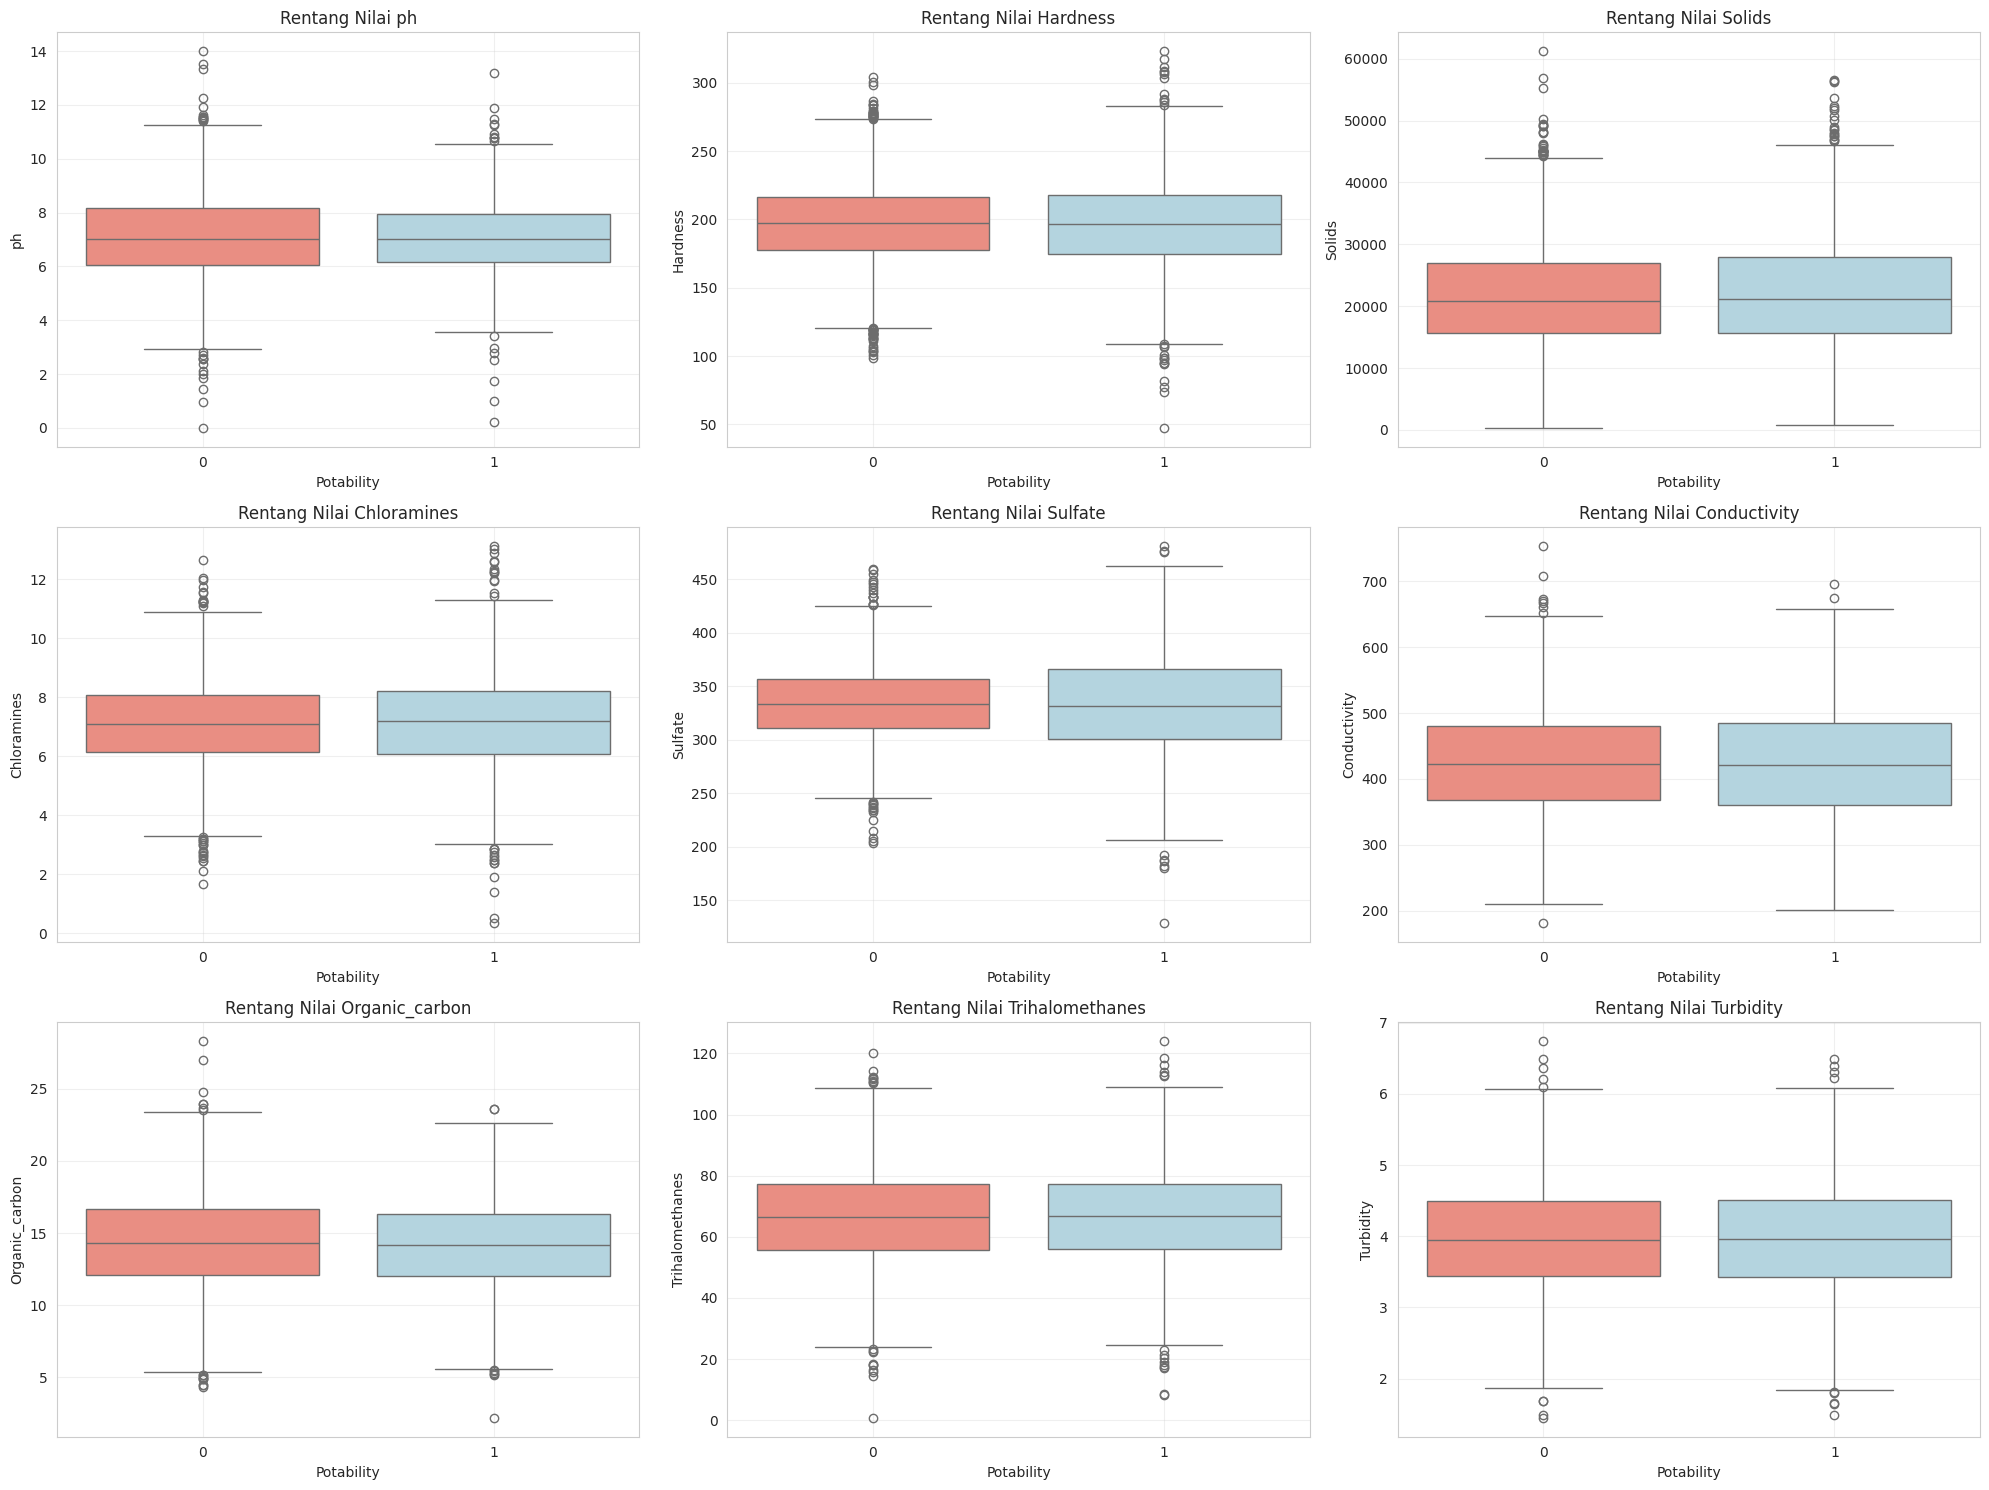

In [ ]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(features):
    plt.subplot(3, 3, i + 1)

    # Boxplot: Sumbu X adalah Target, Sumbu Y adalah Nilai Kimia
    sns.boxplot(x='Potability', y=col, data=df, palette={'0': "salmon", '1': "lightblue"})

    plt.title(f'Rentang Nilai {col}', fontsize=12)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## PAIRPLOT (HUBUNGAN ANTAR FITUR)

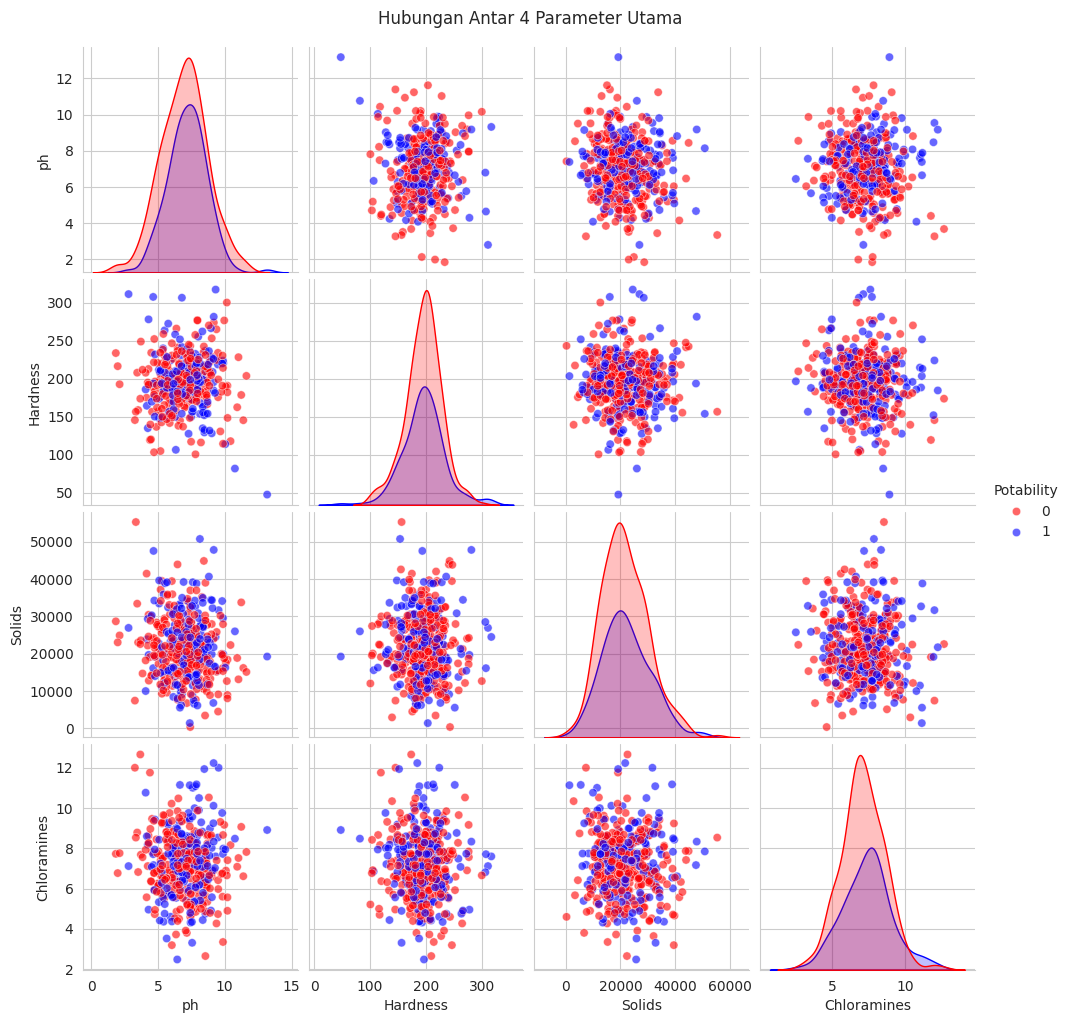

In [ ]:
# Kita ambil sampel saja (misal 500 data) agar plotting tidak berat/lag
df_sample = df.sample(n=500, random_state=42)

# Plotting hubungan antar 4 fitur utama (biar tidak terlalu kecil gambarnya)
# Misal: ph, Hardness, Solids, Chloramines
selected_features = ['ph', 'Hardness', 'Solids', 'Chloramines', 'Potability']

sns.pairplot(df_sample[selected_features], hue='Potability', palette={0: 'red', 1: 'blue'}, diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle('Hubungan Antar 4 Parameter Utama', y=1.02)
plt.show()

## Simpan Model dan Scaler

In [ ]:
# Simpan Model dan Scaler
joblib.dump(best_rf, 'model_water_rf.pkl')
joblib.dump(scaler, 'scaler_water.pkl')
joblib.dump(imputer, 'imputer_water.pkl')

print("Model, Scaler, dan Imputer berhasil disimpan!")
print("Siap digunakan untuk deployment Streamlit.")

Model, Scaler, dan Imputer berhasil disimpan!
Siap digunakan untuk deployment Streamlit.
